# Elaine Zhang Sleep Inference

## Importing Data and Data Cleaning

In [23]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt

In [7]:
file_path = "EZ_data/History.json"

with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)  # Load JSON data

history_list = data["Browser History"]  # Extract history data
elaine_chrome_history = pd.DataFrame(history_list)
elaine_chrome_history.head(1)


,favicon_url,page_transition_qualifier,title,url,time_usec,client_id
0,,CLIENT_REDIRECT,cs6501-4501-analyzing-online-behavior,https://henrykautz.com/Teaching/cs6501-4501-an...,1739462350537799,GDY74/DpgCDxMCldA15OWg==


In [8]:
elaine_chrome_history["datetime"] = pd.to_datetime(elaine_chrome_history["time_usec"], unit="us")
elaine_chrome_history["date"] = elaine_chrome_history["datetime"].dt.date  # Extract date (YYYY-MM-DD)
elaine_chrome_history["time"] = elaine_chrome_history["datetime"].dt.time

elaine_chrome_history.head(3)

,favicon_url,page_transition_qualifier,title,url,time_usec,client_id,datetime,date,time
0,,CLIENT_REDIRECT,cs6501-4501-analyzing-online-behavior,https://henrykautz.com/Teaching/cs6501-4501-an...,1739462350537799,GDY74/DpgCDxMCldA15OWg==,2025-02-13 15:59:10.537799,2025-02-13,15:59:10.537799
1,https://www.google.com/favicon.ico,CLIENT_REDIRECT,Google Takeout,https://takeout.google.com/,1739462310560712,GDY74/DpgCDxMCldA15OWg==,2025-02-13 15:58:30.560712,2025-02-13,15:58:30.560712
2,https://www.google.com/favicon.ico,CLIENT_REDIRECT,Google Takeout,https://takeout.google.com/,1739462309304862,GDY74/DpgCDxMCldA15OWg==,2025-02-13 15:58:29.304862,2025-02-13,15:58:29.304862


In [17]:
# tally up keywords
keywords = ["uva", "canvas", "zzb2rf", "drive"]

tally_data = []
last_time_per_date = {}

for _, row in elaine_chrome_history.iterrows():
    row_tally = {"date": row["date"], "total_count": 0}
    
    # Count occurrences of each keyword
    for keyword in keywords:
        count = sum(row.astype(str).str.contains(keyword, case=False, na=False))
        row_tally[keyword] = count
        row_tally["total_count"] += count

    if row["date"] not in last_time_per_date:
        last_time_per_date[row["date"]] = row["time"]
    else:
        if row["time"] > last_time_per_date[row["date"]]:
            last_time_per_date[row["date"]] = row["time"]
    
    tally_data.append(row_tally)

tally_df = pd.DataFrame(tally_data)
summary_df = tally_df.groupby("date", as_index=False).sum()
summary_df["last_time"] = summary_df["date"].map(last_time_per_date)

In [18]:
# double check to see if any dates are missing, if so, add them to my df
summary_df["date"] = pd.to_datetime(summary_df["date"])

full_date_range = pd.date_range(start=summary_df["date"].min(), end=summary_df["date"].max(), freq="D")
missing_dates = full_date_range[~full_date_range.isin(summary_df["date"])]

missing_rows = []
for missing_date in missing_dates:
    missing_row = {"date": missing_date, "total_count": 0, "uva": 0, "canvas": 0, "zzb2rf": 0, "drive": 0}
    missing_rows.append(missing_row)
missing_df = pd.DataFrame(missing_rows)

summary_df = pd.concat([summary_df, missing_df], ignore_index=True)
summary_df = summary_df.sort_values("date").reset_index(drop=True)

summary_df.head()

,date,total_count,uva,canvas,zzb2rf,drive,last_time
0,2024-02-14,30,13,15,2,0,21:58:42.685267
1,2024-02-15,10,8,0,2,0,21:20:43.488579
2,2024-02-16,0,0,0,0,0,22:08:20.461036
3,2024-02-17,7,7,0,0,0,22:24:27.512666
4,2024-02-18,61,36,5,1,19,23:58:09.753023


## Sleep Inference

In [60]:
# get the first and last visited websites per date

def get_first_and_last_visits(df):
    # find first and last visited websites per date
    first_visits = df.loc[df.groupby("date")["time"].idxmin()]
    last_visits = df.loc[df.groupby("date")["time"].idxmax()]

    # select relevant columns
    first_visits = first_visits[["date", "time", "url", "title"]].rename(columns={
        "time": "visit_time_first",
        "url": "url_first",
        "title": "title_first"
    })
    
    last_visits = last_visits[["date", "time", "url", "title"]].rename(columns={
        "time": "visit_time_last",
        "url": "url_last",
        "title": "title_last"
    })

    # merge both DataFrames on visit_date to get one row per date
    visit_summary = pd.merge(first_visits, last_visits, on="date")
    visit_summary["visit_time_first"] = pd.to_datetime(visit_summary["visit_time_first"].astype(str), format='%H:%M:%S.%f')
    visit_summary["visit_time_last"] = pd.to_datetime(visit_summary["visit_time_last"].astype(str), format='%H:%M:%S.%f')
    return visit_summary

visit_summary_df = get_first_and_last_visits(elaine_chrome_history)
visit_summary_df.tail()

,date,visit_time_first,url_first,title_first,visit_time_last,url_last,title_last
289,2025-02-09,1900-01-01 02:06:26.151322,https://www.google.com/search?q=apple+watch+le...,apple watch leather band - Google Search,1900-01-01 23:14:02.739936,https://www.google.com/search?q=what+time+does...,what time does the super bowl end at - Google ...
290,2025-02-10,1900-01-01 00:01:54.873355,https://www.google.com/search?q=garmin+watch+m...,garmin watch menstrual tracking - Google Search,1900-01-01 23:09:19.565611,https://www.instagram.com/maggierogers/,"Maggie Rogers | quietly, slowly | Instagram"
291,2025-02-11,1900-01-01 00:52:05.149991,https://genderedinnovations.stanford.edu/case-...,Medical Technology | Gendered Innovations,1900-01-01 23:51:47.171064,https://canvas.its.virginia.edu/,Dashboard
292,2025-02-12,1900-01-01 00:46:19.244143,https://canvas.its.virginia.edu/,Dashboard,1900-01-01 23:01:51.800060,https://mail.google.com/mail/u/3/?ogbl#inbox,"Inbox (7,675) - zzb2rf@virginia.edu - UVa Mail"
293,2025-02-13,1900-01-01 15:57:10.355158,https://shibidp.its.virginia.edu/idp/profile/S...,NetBadge Message - Loading Session Information,1900-01-01 15:59:10.537799,https://henrykautz.com/Teaching/cs6501-4501-an...,cs6501-4501-analyzing-online-behavior


In [24]:
sleep_df = pd.read_csv('elaine_sleep_data.csv')

In [61]:
print(visit_summary_df["visit_time_first"].dtype)
visit_summary_df["visit_time_last"] = pd.to_datetime(visit_summary_df["visit_time_last"])


datetime64[ns]


datetime64[ns]


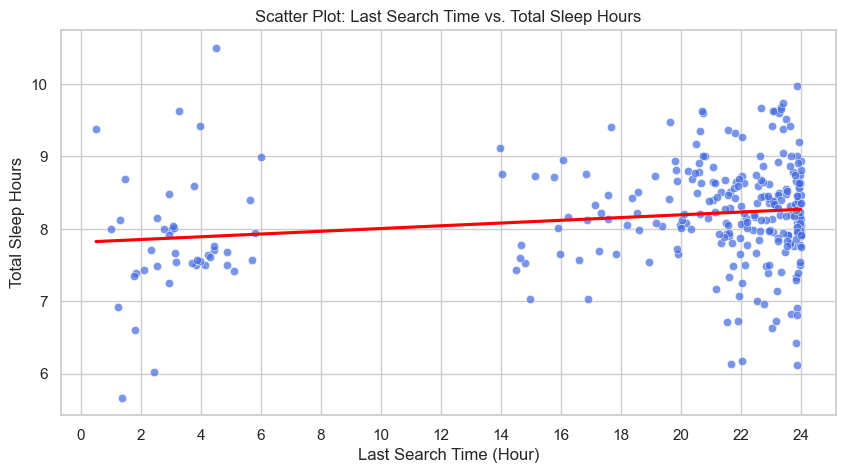

ValueError: bins must increase monotonically.

In [63]:
sns.set_theme(style="whitegrid")

# Convert datetime columns
sleep_df["Date"] = pd.to_datetime(sleep_df["Date"])  # Sleep recorded by morning of the date
# visit_summary_df["date"] = pd.to_datetime(visit_summary_df["date"])

print(visit_summary_df["visit_time_first"].dtype)

visit_summary_df["Sleep Date"] = visit_summary_df["date"].where(
    visit_summary_df["visit_time_last"].dt.hour < 4,  # Check if search time is before 4 AM
    visit_summary_df["date"] - pd.Timedelta(days=1)  # Subtract one day if it's after 4 AM
)

# Merge sleep and search data
merged_df = sleep_df.merge(visit_summary_df, left_on="Date", right_on="Sleep Date", how="left")

# Convert last search time into a numeric hour for plotting
merged_df["search_hour"] = pd.to_datetime(merged_df["visit_time_last"], format="%H:%M:%S").dt.hour + \
                            pd.to_datetime(merged_df["visit_time_last"], format="%H:%M:%S").dt.minute / 60

plt.figure(figsize=(10, 5))
sns.scatterplot(data=merged_df, x="search_hour", y="total_sleep_hours", alpha=0.7, color="royalblue")
sns.regplot(data=merged_df, x="search_hour", y="total_sleep_hours", scatter=False, color="red", ci=None)  # Trendline
plt.xlabel("Last Search Time (Hour)")
plt.ylabel("Total Sleep Hours")
plt.title("Scatter Plot: Last Search Time vs. Total Sleep Hours")
plt.xticks(range(0, 25, 2))  # Show time as hours
plt.show()

merged_df["search_range"] = pd.cut(
    merged_df["search_hour"],
    bins=[0, 22, 24, 2, 12],  # Before 10 PM, 10 PM–12 AM, 12 AM–2 AM, 2 AM–Noon
    labels=["Before 10 PM", "10 PM–12 AM", "12 AM–2 AM", "2 AM–Noon"],
    ordered=True
)

plt.figure(figsize=(8, 5))
sns.boxplot(data=merged_df, x="search_range", y="total_sleep_hours", palette="coolwarm")
sns.stripplot(data=merged_df, x="search_range", y="total_sleep_hours", color="black", alpha=0.3, jitter=True)  # Add individual points
plt.xlabel("Last Search Time Range")
plt.ylabel("Total Sleep Hours")
plt.title("Box Plot: Sleep Duration by Last Search Time Range")
plt.show()

plt.figure(figsize=(8, 5))
sns.violinplot(data=merged_df, x="search_range", y="total_sleep_hours", palette="coolwarm", inner="quartile")
plt.xlabel("Last Search Time Range")
plt.ylabel("Total Sleep Hours")
plt.title("Violin Plot: Sleep Distribution by Last Search Time Range")
plt.show()
